In [76]:
import numpy as np
import scipy.signal
import scipy.optimize
import matplotlib.pyplot as plt
import sympy as sp
import control as ctl

# FUNÇÃO DE TRANSFERÊNCIA

TransferFunction(array([0.02188914, 0.        ]), array([ 1.        , -3.59252599]))

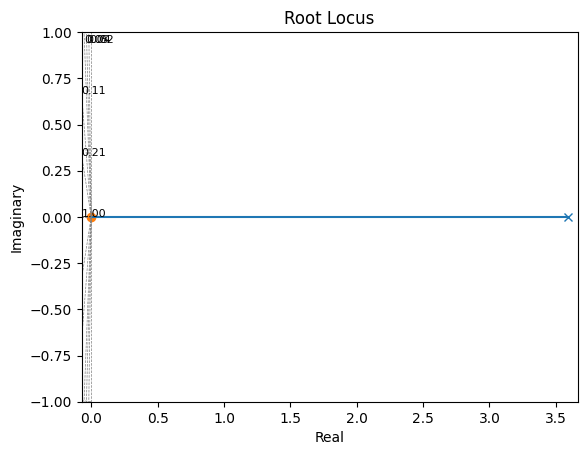

In [77]:
s = ctl.TransferFunction.s
G =  0.0218891424389763*s/(1.0*s - 3.592525994444)

display(G)
_ = ctl.root_locus(G, plot=True)

[0.02188914 0.        ]
[ 1.         -3.59252599]


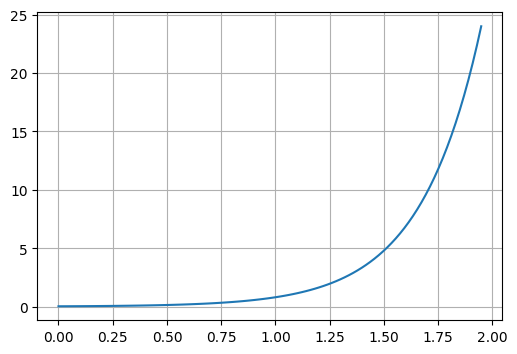

In [78]:
num, den = (G.num[0][0], G.den[0][0])
print(num)
print(den)

G = scipy.signal.lti(num, den)
time, response = G.step()

plt.figure(figsize=(6, 4))
plt.plot(time, response)
plt.grid()

# PARÂMETROS DO CONTROLADOR
- **M** define o número de passos de controle no horizonte de controle. Ele representa o período durante o qual o controlador pode ajustar as entradas (ações de controle) para tentar alcançar o setpoint. Esse valor é geralmente menor que o horizonte de predição, pois o controle é aplicado em uma janela mais curta, com o objetivo de minimizar o erro no futuro imediato.

- **P** representa o horizonte de predição, ou seja, quantos passos futuros o controlador tentará prever para ajustar a resposta do sistema. Ele define a "visão de futuro" do controlador, onde ele considera os valores de saída esperados em relação ao setpoint para minimizar os erros. Um horizonte de predição mais longo permite que o controlador tenha uma visão mais ampla do comportamento futuro.

- **dt** é o intervalo de tempo entre cada amostra, definindo o ritmo com que o sistema é atualizado e a frequência com que o controlador ajusta as ações de controle. No contexto de controle preditivo, dt afeta a resolução da previsão e controle, pois determina a granularidade do tempo, em que valores menores de dt permitem previsões mais detalhadas.

In [79]:
M = 80  # Control horizon
P = 160  # Prediction horizon
dt = 0.01  # Sampling rate

limits = (-500, 500)
bounds = [limits for i in range(M)]

- **rData** é o sinal de referência, definido como uma função exponencial que converge para o valor setpoint = 6. Esse é o objetivo que o controlador tenta alcançar e simulamos um comportamento ideal

- **tData** é o vetor no tempo discreto tem o tamanho do horizonte de predição

- **uData** é o vetor de controle que contém os valores de entrada aplicados ao sistema para aproximá-lo do setpoint desejado. Inicialmente, é definido com valores constantes, mas será ajustado pela otimização para minimizar o erro entre a resposta do sistema e o objetivo.

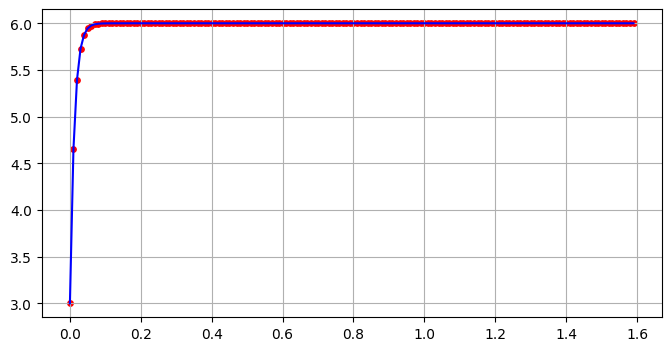

In [80]:
Ts = 20
Xo = 3
setpoint = 6
tData = np.arange(0, P*dt, dt)
uData = np.ones(M)
rData = Xo + (setpoint - Xo) * (1 - np.exp(-4*Ts * tData))

plt.figure(figsize=(8, 4))
plt.plot(tData, rData, color='blue')
plt.scatter(tData, rData, s=15, color='red')
plt.grid()
plt.show()

- Convertendo a função de transferência para espaço de estados, é sempre melhor trabalhar com matrizes quando estamos lidando com controladores mais complexos

In [81]:
matrix = G.to_ss()
A, B, C, D = matrix.A, matrix.B, matrix.C, matrix.D

display(sp.Matrix(A))
display(sp.Matrix(B))
display(sp.Matrix(C))
display(sp.Matrix(D))

Matrix([[3.592525994444]])

Matrix([[1.0]])

Matrix([[0.0786373132081097]])

Matrix([[0.0218891424389763]])

In [82]:
print('dimensão da matriz A:', A.shape)
print('ordem do sistema:', A.shape[0])

n  = A.shape[0]
x0 = Xo * np.ones(n)
x0

dimensão da matriz A: (1, 1)
ordem do sistema: 1


array([3.])

- Forçando uma resposta no sistema $G$ com base em um vetor de entrada
- A função extendArray aumentando o tamanho do vetor de entrada $u$ para o tamanho que falta P, repetindo seu último valor

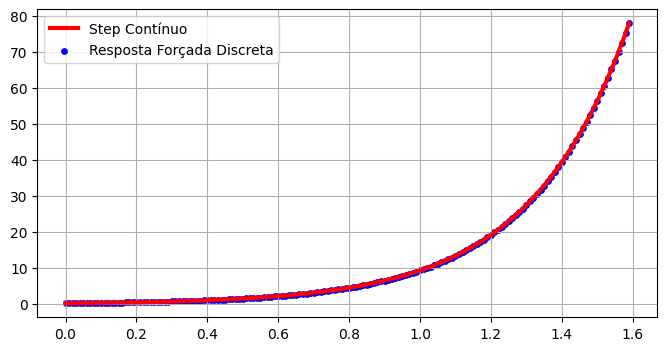

In [83]:
def extendArray(array, newSize):
    n = newSize - len(array)
    newData = np.repeat(array[-1], n)
    return np.concatenate([array, newData])

def forcedResponse(G, U, T, Xo):
    return scipy.signal.lsim(G, U=U, T=T, X0=Xo, interp=False)[1]


yData = forcedResponse(G, T=tData, U=extendArray(uData, P), Xo=x0)
time, response = G.step(T=tData, X0=x0)

plt.figure(figsize=(8, 4))
plt.plot(time, response, color='red', linewidth=3, label='Step Contínuo')
plt.scatter(tData, yData, color='blue', s=15, label='Resposta Forçada Discreta')
plt.grid()
plt.legend()

# TREINANDO MODELO
- A função abaixo calcula a soma dos quadrados dos erros para saber a distancia que estamos do objetivo (diferença entre o setpoint e a entrada), ou seja, é o erro com base nos valores de um vetor

In [84]:
def getError(u, T, Xo):
    yData = forcedResponse(G, U=extendArray(u, P), T=T, Xo=Xo)
    return sum((rData - yData)**2)


getError(uData, T=tData, Xo=x0) # erro mt grande

66998.05154390466

- Com a medição do erro medido em objective, usamos scipy.optimize para encontrar a saída que minimiza esse erro, ou seja, qual é a entrada que temos que aplicar para minimizar esse erro

In [85]:
result = scipy.optimize.minimize(getError, uData, args=(tData, x0), bounds=bounds)
result

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 1436.204977543047
        x: [ 3.476e+01  1.085e+02 ... -3.400e+02 -5.000e+02]
      nit: 34
      jac: [-5.866e-03 -5.457e-03 ... -4.547e-05  2.385e+00]
     nfev: 5265
     njev: 65
 hess_inv: <80x80 LbfgsInvHessProduct with dtype=float64>

In [86]:
error = result.fun
error

1436.204977543047

# TESTANDO MODELO

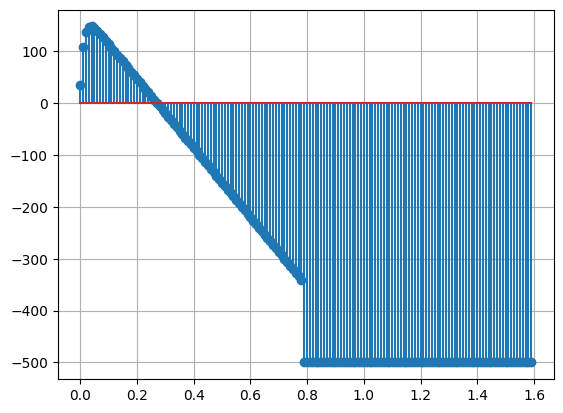

In [87]:
output = result.x
output = extendArray(output, len(tData))

plt.stem(tData, output)
plt.grid()

In [88]:
len(result.x) == M # próximas 10 ações de conrole

True

Resample the discrete output to continuous time (effectively work out the 0 order hold value)

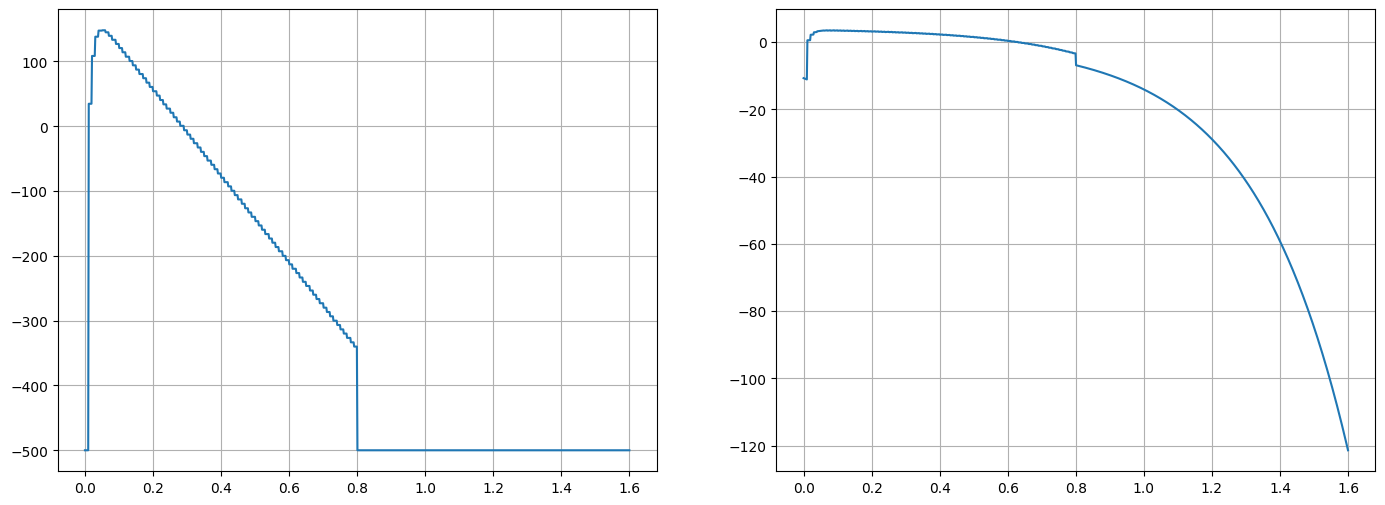

In [89]:
def getContinousArray(time, response, dt):
    indices = (time - 0.01) // dt
    return response[indices.astype(int)]


tData  = np.linspace(0, P*dt, 1000)  
output = getContinousArray(tData, output, dt)
yData = forcedResponse(G, U=output, T=tData, Xo=x0)


plt.figure(figsize=(17, 6))
plt.subplot(1, 2, 1)
plt.plot(tData, output)
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(tData, yData)
plt.grid()